In [1]:
!pip install torch_snippets
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 1.4 MB/s 
     |████████████████████████████████| 237 kB 9.1 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 58 kB 5.9 MB/s 
     |████████████████████████████████| 1.6 MB 99.0 MB/s 
     |████████████████████████████████| 174 kB 94.1 MB/s 
     |████████████████████████████████| 2.2 MB 77.8 MB/s 
     |████████████████████████████████| 51 kB 6.8 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=9083e9a1010188a9d8974412e5493607e67fdcd0e25bcd6645968fd3330556b3
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26323 sha256=5a6211afc25fceff0e06e837c78b6bac4f145b5ee97589932d83686ae81f8c2e
  Stored in directory: /root/.ca

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from torchsummary import summary
import torchvision.transforms as T
from torch_snippets import *
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE()

In [3]:
data_folder = '/root/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

cifar10 = torchvision.datasets.CIFAR10(data_folder,train=True,download=True)
data = cifar10.data
target = cifar10.targets

# Two training datasets (original and augmentation) and one validation dataset
x_train, x_val, y_train, y_val = train_test_split(data,target,test_size=0.2,shuffle=True,stratify=target,random_state=34)
# stratify: prevents an imbalanced class ratio by properly distributing images into training and validation 

# Only 10% labelled data is to be used for training the linear classifier
x_train_10_percent = x_train[:round(len(x_train)*0.1)]
y_train_10_percent = y_train[:round(len(x_train)*0.1)]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/cifar-10-python.tar.gz to /root/


In [4]:
# Create a dictionary for mapping between class names and numbers
mapping = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
inverse_mapping = {0,1,2,3,4,5,6,7,8,9}
#mapping = {'airplane':0,'automobile':1,'bird':2,'cat':3,'deer':4,'dog':5,'frog':6,'horse':7,'ship':8,'truck':9}
#inverse_mapping = {'airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'}

In [11]:
def get_augmentation(s=1.0):
  color_jitter = A.ColorJitter(contrast=s*0.2,saturation=s*0.2,hue=s*0.2,p=0.8)
  rnd_gray = A.ToGray(p=0.2)
  color_augment = A.Compose([
      color_jitter,
      rnd_gray
  ])
  return color_augment

class CIFAR_Dataset(Dataset):
  def __init__(self,images,targets,mutation=False):
    self.images = images
    self.targets = targets
    self.mutation = mutation
  def __len__(self): return len(self.targets)
  def tensor_normalization(self,image):
    normalize = A.Normalize((0.5,0.5,0.5),
                            (0.5,0.5,0.5))
    to_tensor = ToTensorV2()
    res = A.Compose([
        normalize,
        to_tensor
    ])(image=image)
    return res["image"]
  def augment_image(self,image):
    res = A.RandomResizedCrop(height=224,width=224)(image=image)
    res = get_augmentation(s=1)(image=res["image"])
    return res["image"]
  def __getitem__(self,idx):
    image, target = self.images[idx], self.targets[idx]
    #img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    img = A.Resize(height=250,width=250)(image=image)
    img = img["image"]
    if self.mutation:
      image1 = self.augment_image(img)
      image1 = self.tensor_normalization(image1)
      image2 = self.augment_image(img)
      image2 = self.tensor_normalization(image2)
      sample = {'image1':image1, 'image2':image2, 'label':target}
    else:
      image = A.Resize(height=250,width=250)(image=img)
      image = self.tensor_normalization(image["image"])
      sample = {'image':image,'label':target}
    return sample

In [12]:
def get_data():
  train = CIFAR_Dataset(x_train_10_percent,y_train_10_percent,mutation=False)
  trn_dl = DataLoader(train,batch_size=125,shuffle=True)

  train_mutation = CIFAR_Dataset(x_train,y_train,mutation=True)
  trn_mutation_dl = DataLoader(train_mutation,batch_size=250,shuffle=True)

  val = CIFAR_Dataset(x_val,y_val)
  val_dl = DataLoader(val,batch_size=250,shuffle=True)
  return trn_dl, trn_mutation_dl, val_dl

trn_dl, trn_mutation_dl, val_dl = get_data()

In [13]:
from torchvision.models import resnet18
from collections import OrderedDict
resnet = resnet18(pretrained=False)

classifier = nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(resnet.fc.in_features,100)),
    ('added_relu1',nn.ReLU(inplace=True)),
    ('fc2',nn.Linear(100,50)),
    ('added_relu2',nn.ReLU(inplace=True)),
    ('fc3',nn.Linear(50,25))
]))

resnet.fc = classifier
resnet.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
tau = 0.05
def loss_fn(a,b):
    a_norm = torch.norm(a,dim=1).reshape(-1,1)
    a_cap = torch.div(a,a_norm)
    b_norm = torch.norm(b,dim=1).reshape(-1,1)
    b_cap = torch.div(b,b_norm)
    a_cap_b_cap = torch.cat([a_cap,b_cap],dim=0)
    a_cap_b_cap_transpose = torch.t(a_cap_b_cap)
    b_cap_a_cap = torch.cat([b_cap,a_cap],dim=0)
    sim = torch.mm(a_cap_b_cap,a_cap_b_cap_transpose)
    sim_by_tau = torch.div(sim,tau)
    exp_sim_by_tau = torch.exp(sim_by_tau)
    sum_of_rows = torch.sum(exp_sim_by_tau, dim=1)
    exp_sim_by_tau_diag = torch.diag(exp_sim_by_tau)
    numerators = torch.exp(torch.div(torch.nn.CosineSimilarity()(a_cap_b_cap,b_cap_a_cap),tau))
    denominators = sum_of_rows - exp_sim_by_tau_diag
    num_by_den = torch.div(numerators,denominators)
    neglog_num_by_den = -torch.log(num_by_den)
    return torch.mean(neglog_num_by_den)

In [28]:
optimizer = optim.SGD(resnet.parameters(),lr=0.001,momentum=0.9)

def plot_vecs_n_labels(v,labels,fname):
    fig = plt.figure(figsize = (10, 10))
    plt.axis('off')
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 10))
    plt.legend(['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'])
    plt.savefig(fname)
    plt.close()

def train_batch_mutated(batch_ds,resnet,loss_fn,optimizer):
  resnet.train()
  x1 = batch_ds['image1'].to(device)
  x2 = batch_ds['image2'].to(device)

  y1 = resnet(x1)
  y2 = resnet(x2)

  loss = loss_fn(y1,y2)
  loss.backward()

  optimizer.step()
  optimizer.zero_grad()
  return loss.item()

@torch.no_grad()
def train_batch_10_percent(batch_ds,resnet,tsne):
  resnet.eval()
  x = batch_ds['image'].to(device)
  y = resnet(x)
  y_tsne = tsne.fit_transform(y.cpu().data)
  labels = batch_ds['label']
  plot_vecs_n_labels(y_tsne,labels,'tsne_train_last_layer.png')

def validate_batch(batch_ds,resnet,tsne):
  resnet.eval()
  x = batch_ds['image'].to(device)
  y = resnet(x)
  y_tsne = tsne.fit_transform(y.cpu().data)
  labels = batch_ds['label']
  plot_vecs_n_labels(y_tsne,labels,'tsne_val_last_layer.png')

In [29]:
n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):
  N = len(trn_mutation_dl)
  for ix, data in enumerate(iter(trn_mutation_dl)):
    loss = train_batch_mutated(data,resnet,loss_fn,optimizer)
    log.record(epoch+(ix+1)/N,trn_loss=loss,end='\r')

  N = len(trn_dl)
  for ix, data in enumerate(iter(trn_dl)):
    train_batch_10_percent(data,resnet,tsne)
  
  N = len(val_dl)
  for _, data in enumerate(iter(val_dl)):
    validate_batch(data,resnet,tsne)
  log.report_avgs(epoch+1)

EPOCH: 1.000  trn_loss: 4.226  (220.21s - 880.85s remaining)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

EPOCH: 1.000  trn_loss: 4.262  (308.67s - 1234.70s remaining)
EPOCH: 2.000  trn_loss: 3.424  (526.47s - 789.71s remaining)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

EPOCH: 2.000  trn_loss: 3.737  (615.47s - 923.20s remaining)
EPOCH: 3.000  trn_loss: 3.053  (834.50s - 556.33s remaining)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

EPOCH: 3.000  trn_loss: 3.354  (923.95s - 615.97s remaining)
EPOCH: 4.000  trn_loss: 3.174  (1144.15s - 286.04s remaining)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

EPOCH: 4.000  trn_loss: 3.088  (1233.23s - 308.31s remaining)
EPOCH: 5.000  trn_loss: 2.424  (1453.71s - 0.00s remaining)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

EPOCH: 5.000  trn_loss: 2.869  (1543.27s - 0.00s remaining)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


100%|██████████| 106/106 [00:00<00:00, 5869.41it/s]


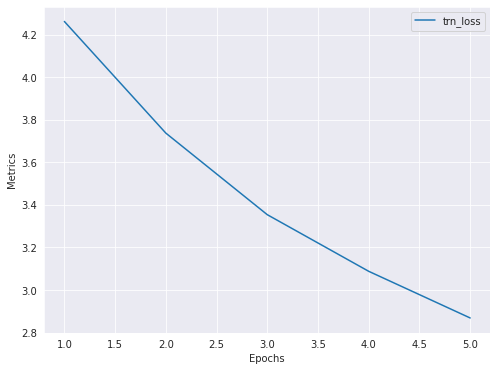

In [30]:
log.plot_epochs(['trn_loss'])

In [31]:
# Remove the last layer incrementally
resnet.fc = nn.Sequential(*list(resnet.fc.children())[:-2])
n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):
  N = len(trn_mutation_dl)
  for ix, data in enumerate(iter(trn_mutation_dl)):
    loss = train_batch_mutated(data,resnet,loss_fn,optimizer)
    log.record(epoch+(ix+1)/N,trn_loss=loss,end='\r')

  N = len(trn_dl)
  for _, data in enumerate(iter(trn_dl)):
    train_batch_10_percent(data,resnet,tsne)
  
  N = len(val_dl)
  for _, data in enumerate(iter(val_dl)):
    validate_batch(data,resnet,tsne)
  log.report_avgs(epoch+1)

EPOCH: 1.000  trn_loss: 2.441  (218.69s - 874.75s remaining)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

EPOCH: 1.000  trn_loss: 2.843  (307.67s - 1230.68s remaining)
EPOCH: 2.000  trn_loss: 2.679  (522.09s - 783.13s remaining)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

EPOCH: 2.000  trn_loss: 2.535  (610.23s - 915.34s remaining)
EPOCH: 3.000  trn_loss: 2.208  (824.94s - 549.96s remaining)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

EPOCH: 3.000  trn_loss: 2.395  (912.96s - 608.64s remaining)
EPOCH: 4.000  trn_loss: 2.411  (1126.91s - 281.73s remaining)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

EPOCH: 4.000  trn_loss: 2.274  (1214.67s - 303.67s remaining)
EPOCH: 5.000  trn_loss: 2.138  (1430.64s - 0.00s remaining)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

EPOCH: 5.000  trn_loss: 2.175  (1519.03s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 5383.56it/s]


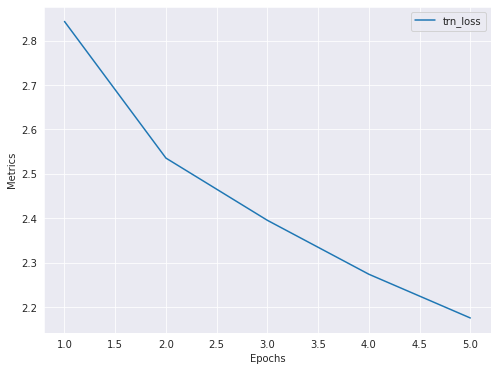

In [32]:
log.plot_epochs(['trn_loss'])

In [33]:
resnet.fc = nn.Sequential(*list(resnet.fc.children())[:-1])
n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):
  N = len(trn_mutation_dl)
  for ix, data in enumerate(iter(trn_mutation_dl)):
    loss = train_batch_mutated(data,resnet,loss_fn,optimizer)
    log.record(epoch+(ix+1)/N,trn_loss=loss,end='\r')

  N = len(trn_dl)
  for _, data in enumerate(iter(trn_dl)):
    train_batch_10_percent(data,resnet,tsne)
  
  N = len(val_dl)
  for _, data in enumerate(iter(val_dl)):
    validate_batch(data,resnet,tsne)
  log.report_avgs(epoch+1)

EPOCH: 1.000  trn_loss: 2.422  (221.30s - 885.20s remaining)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

EPOCH: 1.000  trn_loss: 2.567  (311.06s - 1244.23s remaining)
EPOCH: 2.000  trn_loss: 2.297  (525.10s - 787.65s remaining)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

EPOCH: 2.000  trn_loss: 2.301  (613.79s - 920.68s remaining)
EPOCH: 3.000  trn_loss: 2.170  (827.77s - 551.84s remaining)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

EPOCH: 3.000  trn_loss: 2.212  (916.18s - 610.79s remaining)
EPOCH: 4.000  trn_loss: 2.027  (1130.35s - 282.59s remaining)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

EPOCH: 4.000  trn_loss: 2.141  (1219.41s - 304.85s remaining)
EPOCH: 5.000  trn_loss: 1.903  (1440.14s - 0.00s remaining)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

EPOCH: 5.000  trn_loss: 2.058  (1530.59s - 0.00s remaining)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


100%|██████████| 106/106 [00:00<00:00, 5396.70it/s]


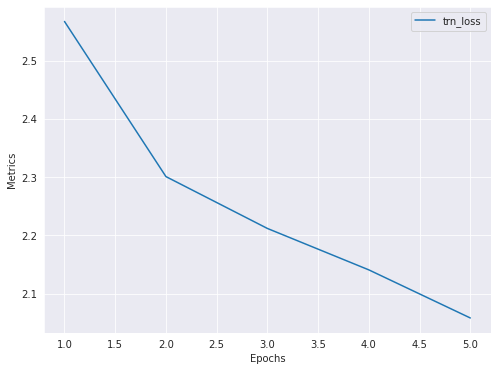

In [34]:
log.plot_epochs(['trn_loss'])

In [48]:
class LinearNet(nn.Module):

    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = torch.nn.Linear(100, 10)

    def forward(self, x):
        x = self.fc1(x)
        return(x)

linear_classifier = LinearNet()
linear_classifier.to(device)
linear_optimizer = optim.SGD(linear_classifier.parameters(),lr=0.1,momentum=0.9,weight_decay=1e-6)
loss_fn = nn.CrossEntropyLoss()

def get_loss(preds,targets):
  loss = loss_fn(preds,targets)
  acc = (torch.max(preds,1)[1]==targets).float().mean()
  return loss, acc

criterion = get_loss

def train_linear_classifier(batch_ds,model,resnet,optimizer,criterion):
  model.train()
  x = batch_ds['image'].to(device)
  y = batch_ds['label'].to(device)

  y_intermediate = resnet(x)
  optimizer.zero_grad()

  y_pred = model(y_intermediate)

  loss, acc = criterion(y_pred,y)
  loss.backward()

  optimizer.step()
  return loss.item(), acc.item()

@torch.no_grad()
def validate_linear_classifier(batch_ds,model,resnet,criterion):
  model.eval()
  x = batch_ds['image'].to(device)
  y = batch_ds['label'].to(device)
  y_intermediate = resnet(x)
  y_pred = model(y_intermediate)
  loss, acc = criterion(y_pred,y)

  return loss.item(), acc.item()

In [50]:
n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):
  N = len(trn_dl)
  for ix, data in enumerate(iter(trn_dl)):
    loss, acc = train_linear_classifier(data,linear_classifier,resnet,linear_optimizer,criterion)
    log.record(epoch+(ix+1)/N,trn_loss=loss,trn_acc=acc,end='\r')

  N = len(val_dl)
  for ix, data in enumerate(iter(val_dl)):
    loss, acc = validate_linear_classifier(data,linear_classifier,resnet,criterion)
    log.record(epoch+(ix+1)/N,val_loss=loss,val_acc=acc,end='\r')
  log.report_avgs(epoch+1)

EPOCH: 1.000  trn_acc: 0.505  val_acc: 0.480  trn_loss: 1.433  val_loss: 1.468  (27.86s - 111.43s remaining)
EPOCH: 2.000  trn_acc: 0.505  val_acc: 0.488  trn_loss: 1.409  val_loss: 1.439  (55.63s - 83.45s remaining)
EPOCH: 3.000  trn_acc: 0.519  val_acc: 0.491  trn_loss: 1.381  val_loss: 1.429  (83.50s - 55.67s remaining)
EPOCH: 4.000  trn_acc: 0.524  val_acc: 0.499  trn_loss: 1.367  val_loss: 1.417  (111.27s - 27.82s remaining)
EPOCH: 5.000  trn_acc: 0.519  val_acc: 0.498  trn_loss: 1.352  val_loss: 1.415  (139.11s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 12954.44it/s]


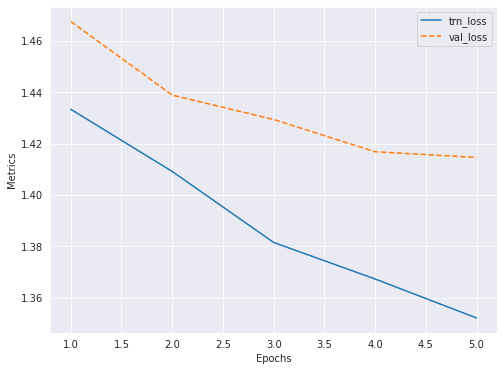

In [51]:
log.plot_epochs(['trn_loss','val_loss'])

100%|██████████| 106/106 [00:00<00:00, 12009.62it/s]


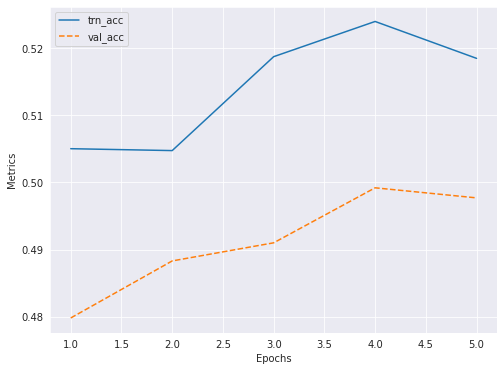

In [52]:
log.plot_epochs(['trn_acc','val_acc'])